# Data Simulations EDA

## Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", message=r"elementwise", category=FutureWarning)

## Import DataCreator class

In [2]:
from DataReader import DataReader

## Data Exploration

In [3]:
data_instance = DataReader()

In [4]:
N_Ref = 200000
N_Bkg = 10000
N_Sig = 0

In [5]:
ref_df = data_instance.build_sample(file_name='RUN001252_cut_shifted_hstat_condor.txt', n_data=N_Ref)
# data_instance.save_distribution('reference_distribution.txt')

data_df = data_instance.build_sample(file_name='RUN001252_cut_shifted_hstat_condor.txt', n_data=N_Bkg)
# data_instance.save_distribution('data_distribution.txt')

### Method 1

In [7]:
ref_target = np.zeros(N_Ref)
data_target = np.ones(N_Bkg+N_Sig)
target = np.append(ref_target, data_target)
target = np.expand_dims(target, axis=1)

In [21]:
target

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

In [9]:
feature = np.concatenate((ref_df, data_df), axis=0)
feature = np.expand_dims(feature, axis=1)
feature = np.concatenate((feature, target), axis=1)
np.random.shuffle(feature)

In [22]:
feature

array([[ 40.       ,   0.       ],
       [228.328125 ,   0.       ],
       [ 77.5      ,   0.       ],
       ...,
       [ 84.1640625,   0.       ],
       [332.5      ,   0.       ],
       [ 50.8359375,   0.       ]])

In [11]:
dataF = pd.DataFrame({'feature':feature[:, 0], 'target':feature[:, -1]})
dataF.loc[(dataF['target']==0, 'Distribution')] = 'REF'
dataF.loc[(dataF['target']==1, 'Distribution')] = 'DATA'

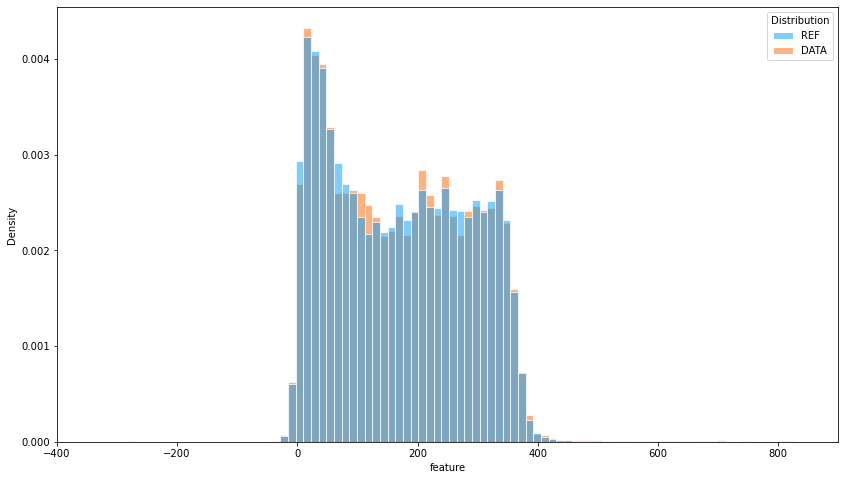

In [19]:
# creo figure&axes
fig, ax = plt.subplots(figsize=(14,8))

ax=sns.histplot(data=dataF, x='feature', hue='Distribution', stat='density', element='bars', fill=True, common_norm=False,
             common_bins=True, bins = 100, palette=['#009AFF', '#ff6500'], edgecolor='white', multiple='layer', )

ax.set_xlim(-400, 900)

plt.show()

### Method 2

In [13]:
ref_hist, ref_bins = np.histogram(ref_df, bins=100, density=False)
data_hist, data_bins = np.histogram(data_df, bins=ref_bins, density=False)

In [14]:
def middle_point(array):
    mid_points = [(array[i]+array[i+1])/2 for i in np.arange(len(array)-1)]
    return np.array(mid_points)

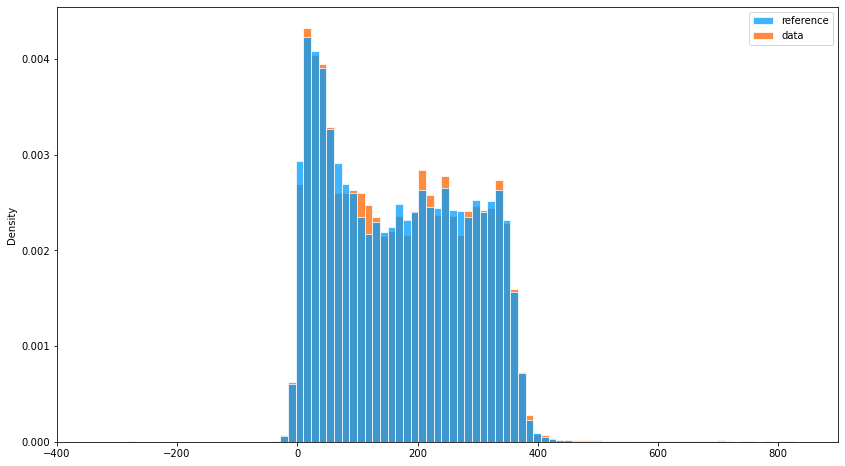

In [17]:
# creo figure&axes
fig, ax = plt.subplots(figsize=(14,8))

# istogramma reference
ax = sns.histplot(x=middle_point(ref_bins),  bins=ref_bins, weights=ref_hist,
                  stat='density', element='bars', fill=True, color='#009cff', edgecolor='white', zorder=1, label='reference')


# istogramma data
ax = sns.histplot(x=middle_point(data_bins),  bins=data_bins, weights=data_hist,
                  stat='density', element='bars', fill=True, color='#ff6500', edgecolor='white', zorder=0, label='data')

ax.set_xlim(-400, 900)

ax.legend()
plt.show()